In [34]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import json, os, re, shutil, sys, time
from importlib import reload
import collections, itertools
import unittest
from IPython.display import display, HTML

# NLTK for NLP utils and corpora
import nltk

# Pandas NumPy and TensorFlow
import pandas as pd
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("1."))

# Helper libraries
from utils import utils_proj, vocabulary

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import lstm; reload(lstm)
import matplotlib.pyplot as plt

% matplotlib inline

In [98]:
def load_train():
    names = ['timestamp','date','query','handle','message']
    df = pd.read_csv('../sentiment140.csv',encoding='Latin1',names=names)
    df['sentiment'] = df.index
    #Instead of positive being 4 make positive 1
    df.loc[df['sentiment'] == 4,'sentiment']=1
    
    return df
    
def build_vocab(x_data):
    
    #build the vocab
    flat_list = [item for sublist in x_data for item in sublist]
    vocab = utils_proj.build_vocab(flat_list)
    
    return vocab
    
def longest_tweet(x_data):
    #Determine the length of the longest tweet
    max_val=0
    for i in x_data:
        if len(i) > max_val:
            max_val = len(i)
    print('Longest tweet :',max_val,'tokens')
    
def preprocess(x_data,vocab,max_time=70):
    #canonicalize sentences, convert to ids,zero pad to consistant length of max_time
    
    max_time=max_time
    
    x_ids = []
    for tweet in x_data:
        temp = utils_proj.preprocess_sentences([tweet],vocab)
        x_ids.append(
            np.pad(utils_proj.preprocess_sentences([tweet],vocab),(max_time-2-len(tweet),0),'constant').tolist()) 
    
    return x_ids


def train_test_dev(x,y,train_pct=.8,test_pct=.1,random_state=1):
    """Split into train dev and test"""
    
    X_train, X_test, y_train, y_test = (
        train_test_split(x, y, test_size=round(1-train_pct,1), random_state=random_state))
    #split test into dev and test
    X_dev, X_test, y_dev, y_test = (
        train_test_split(X_test, y_test, test_size=test_pct/(1-train_pct), random_state=random_state))
    
    
    return np.asarray(X_train),np.asarray(X_dev),np.asarray(X_test),np.asarray(y_train),np.asarray(y_dev),np.asarray(y_test)


In [71]:
#Preprocessing for the train/validation data
df = load_train()

print(df.head())

#Extract x and y columns
x_data = df['message'].tolist()
y_data = df['sentiment'].tolist()
    
    
x_data = [i.split() for i in x_data]

vocab = build_vocab(x_data)

longest_tweet(x_data)
max_time=70
x_ids = preprocess(x_data,vocab)

X_train,X_dev,X_test,y_train,y_dev,y_test = train_test_dev(x_ids,y_data,.67,0)


    timestamp                          date     query           handle  \
0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                             message  sentiment  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0  
0  is upset that he can't update his Facebook by ...          0  
0  @Kenichan I dived many times for the ball. Man...          0  
0    my whole body feels itchy and like its on fire           0  
0  @nationwideclass no, it's not behaving at all....          0  
Vocabulary: 10,000 types
Longest tweet : 64 tokens


In [136]:
data_candidates = pd.read_csv('candidates.csv')

x_data_candidates = data_candidates['tweet'].tolist()
x_data_candidates = [i.split()[:68] for i in x_data_candidates]
x_ids_candidates = np.array(preprocess(x_data_candidates,vocab))


     candidate                                              tweet  \
0  Bill Nelson  "The stakes could not be higher. ... What you ...   
1  Bill Nelson  @FLGovScott @USACEHQ I laugh even in an electi...   
2  Bill Nelson  Governor Rick Scott has been amazing since the...   
3  Bill Nelson  Look out my friends in Florida   You have bill...   
4  Bill Nelson  @GKeile DON'T forget about Rick Scott in Flori...   

                  date  
0  2018-10-28 23:56:02  
1  2018-10-28 23:57:05  
2  2018-10-28 23:57:22  
3  2018-10-28 23:58:03  
4  2018-10-28 23:58:15  


In [73]:
def run_epoch(lm, session, batch_iterator,
              train=False, verbose=False,
              tick_s=60, learning_rate=None):
    
    assert(learning_rate is not None)
    start_time = time.time()
    tick_time = start_time  # for showing status
    total_cost = 0.0  # total cost, summed over all words
    total_batches = 0
    total_tweets = 0
    
    val_acc = []
    y_true = []
    y_pred = []
    
    train_op = lm.optimizer_
    use_dropout = True
    loss = lm.train_loss_

    for i, (w, y) in enumerate(batch_iterator):
       
        y_true.append(y)
        if i == 0:
            h = session.run(lm.initial_h_, {lm.input_w_: w})
        feed_dict = {
            lm.input_w_: w,
            lm.target_y_: y,
            lm.initial_h_: h,
            lm.learning_rate_: learning_rate,

        }
        ops = [loss, lm.final_h_, train_op,lm.accuracy_,lm.predictions_]        

        cost,h,_,batch_acc,preds = session.run(ops,feed_dict=feed_dict)
        
        y_pred.append(preds)
        val_acc.append(batch_acc)
        total_cost += cost
        total_batches = i + 1
        total_tweets += w.shape[0]  

        if verbose and (time.time() - tick_time >= tick_s):
            avg_cost = total_cost / total_batches
            avg_tps = total_tweets / (time.time() - start_time)
            print("[batch {:d}]: seen {:d} tweets at {:.1f} tps, cost = {:.3f}".format(
                i, total_tweets, avg_tps, avg_cost))
            tick_time = time.time()  # reset time ticker
    
    if train:
        return total_cost / total_batches,val_acc
    else:
        return total_cost / total_batches, val_acc,y_true,y_pred

In [74]:
# Training parameters
max_time = max_time
batch_size = 1000
learning_rate = 0.01
num_epochs = 4
TF_GRAPHDIR = "~/w266_final_project/tmp/w266/a3_graph"

# Model parameters
model_params = dict(V=vocab.size, 
                    H=50, 
                    softmax_ns=200,
                    num_layers=2,
                    num_classes=1)

#TF_GRAPHDIR = "/tmp/w266/a3_graph"
summary_writer = tf.summary.FileWriter(TF_GRAPHDIR, lm.graph)
TF_SAVEDIR = "~/w266_final_project/tmp/w266/a3_model"

checkpoint_filename = os.path.join(TF_SAVEDIR, "rnnlm")
trained_filename = os.path.join(TF_SAVEDIR, "rnnlm_trained")

In [75]:
#Run Model Training
reload(lstm)
reload(utils_proj)
print_interval = 5

lm = lstm.RNNLM(**model_params)
lm.BuildCoreGraph()
lm.BuildTrainGraph()

# Explicitly add global initializer and variable saver to LM graph
with lm.graph.as_default():
    initializer = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
# Clear old log directory
shutil.rmtree(TF_SAVEDIR, ignore_errors=True)
if not os.path.isdir(TF_SAVEDIR):
    os.makedirs(TF_SAVEDIR)

with tf.Session(graph=lm.graph) as session:
    # Seed RNG for repeatability
    tf.set_random_seed(42)

    session.run(initializer)
    
    
    for epoch in range(1,num_epochs+1):
        t0_epoch = time.time()
        bi = utils_proj.rnnlm_batch_generator(X_train, batch_size, max_time,y_train)

        cost,val_acc = run_epoch(lm, session, bi,True,
                  True,1.0,learning_rate)
        
        print("[epoch {:d}] Completed in {:s}".format(epoch, utils_proj.pretty_timedelta(since=t0_epoch)))
    
        # Save a checkpoint 
        saver.save(session, checkpoint_filename, global_step=epoch)
   
    #Save final model
    saver.save(session, trained_filename)

[batch 1]: seen 2000 tweets at 1420.8 tps, cost = 0.248
[batch 3]: seen 4000 tweets at 1517.2 tps, cost = 0.248
[batch 5]: seen 6000 tweets at 1560.0 tps, cost = 0.246
[batch 7]: seen 8000 tweets at 1585.3 tps, cost = 0.244
[batch 9]: seen 10000 tweets at 1601.3 tps, cost = 0.242
[batch 11]: seen 12000 tweets at 1608.3 tps, cost = 0.240
[batch 13]: seen 14000 tweets at 1614.3 tps, cost = 0.236
[batch 15]: seen 16000 tweets at 1624.0 tps, cost = 0.235
[batch 17]: seen 18000 tweets at 1630.9 tps, cost = 0.233
[batch 19]: seen 20000 tweets at 1634.6 tps, cost = 0.231
[batch 21]: seen 22000 tweets at 1636.2 tps, cost = 0.229
[batch 23]: seen 24000 tweets at 1636.1 tps, cost = 0.227
[batch 25]: seen 26000 tweets at 1634.7 tps, cost = 0.224
[batch 27]: seen 28000 tweets at 1635.9 tps, cost = 0.223
[batch 29]: seen 30000 tweets at 1634.5 tps, cost = 0.221
[batch 31]: seen 32000 tweets at 1626.2 tps, cost = 0.219
[batch 33]: seen 34000 tweets at 1618.2 tps, cost = 0.217
[batch 35]: seen 36000 

[batch 279]: seen 280000 tweets at 1640.7 tps, cost = 0.159
[batch 281]: seen 282000 tweets at 1640.7 tps, cost = 0.159
[batch 283]: seen 284000 tweets at 1640.9 tps, cost = 0.159
[batch 285]: seen 286000 tweets at 1641.2 tps, cost = 0.159
[batch 287]: seen 288000 tweets at 1641.5 tps, cost = 0.159
[batch 289]: seen 290000 tweets at 1641.8 tps, cost = 0.159
[batch 291]: seen 292000 tweets at 1641.9 tps, cost = 0.159
[batch 293]: seen 294000 tweets at 1642.0 tps, cost = 0.158
[batch 295]: seen 296000 tweets at 1642.2 tps, cost = 0.158
[batch 297]: seen 298000 tweets at 1642.4 tps, cost = 0.158
[batch 299]: seen 300000 tweets at 1642.8 tps, cost = 0.158
[batch 301]: seen 302000 tweets at 1642.9 tps, cost = 0.158
[batch 303]: seen 304000 tweets at 1643.0 tps, cost = 0.158
[batch 305]: seen 306000 tweets at 1643.1 tps, cost = 0.158
[batch 307]: seen 308000 tweets at 1643.1 tps, cost = 0.158
[batch 309]: seen 310000 tweets at 1643.1 tps, cost = 0.157
[batch 311]: seen 312000 tweets at 1643.

[batch 553]: seen 554000 tweets at 1644.4 tps, cost = 0.149
[batch 555]: seen 556000 tweets at 1643.9 tps, cost = 0.149
[batch 557]: seen 558000 tweets at 1643.7 tps, cost = 0.149
[batch 559]: seen 560000 tweets at 1643.6 tps, cost = 0.149
[batch 561]: seen 562000 tweets at 1643.6 tps, cost = 0.149
[batch 563]: seen 564000 tweets at 1643.6 tps, cost = 0.149
[batch 565]: seen 566000 tweets at 1643.7 tps, cost = 0.149
[batch 567]: seen 568000 tweets at 1643.8 tps, cost = 0.149
[batch 569]: seen 570000 tweets at 1643.9 tps, cost = 0.148
[batch 571]: seen 572000 tweets at 1644.0 tps, cost = 0.148
[batch 573]: seen 574000 tweets at 1644.2 tps, cost = 0.148
[batch 575]: seen 576000 tweets at 1644.2 tps, cost = 0.148
[batch 577]: seen 578000 tweets at 1644.3 tps, cost = 0.148
[batch 579]: seen 580000 tweets at 1644.4 tps, cost = 0.148
[batch 581]: seen 582000 tweets at 1644.4 tps, cost = 0.148
[batch 583]: seen 584000 tweets at 1644.3 tps, cost = 0.148
[batch 585]: seen 586000 tweets at 1644.

[batch 827]: seen 828000 tweets at 1647.7 tps, cost = 0.144
[batch 829]: seen 830000 tweets at 1647.6 tps, cost = 0.144
[batch 831]: seen 832000 tweets at 1647.6 tps, cost = 0.144
[batch 833]: seen 834000 tweets at 1647.6 tps, cost = 0.144
[batch 835]: seen 836000 tweets at 1647.5 tps, cost = 0.144
[batch 837]: seen 838000 tweets at 1647.6 tps, cost = 0.144
[batch 839]: seen 840000 tweets at 1647.6 tps, cost = 0.144
[batch 841]: seen 842000 tweets at 1647.7 tps, cost = 0.144
[batch 843]: seen 844000 tweets at 1647.7 tps, cost = 0.144
[batch 845]: seen 846000 tweets at 1647.7 tps, cost = 0.144
[batch 847]: seen 848000 tweets at 1647.7 tps, cost = 0.144
[batch 849]: seen 850000 tweets at 1647.7 tps, cost = 0.144
[batch 851]: seen 852000 tweets at 1647.6 tps, cost = 0.144
[batch 853]: seen 854000 tweets at 1647.6 tps, cost = 0.144
[batch 855]: seen 856000 tweets at 1647.6 tps, cost = 0.144
[batch 857]: seen 858000 tweets at 1647.6 tps, cost = 0.144
[batch 859]: seen 860000 tweets at 1647.

[batch 1097]: seen 1098000 tweets at 1649.1 tps, cost = 0.141
[batch 1099]: seen 1100000 tweets at 1649.1 tps, cost = 0.141
[batch 1101]: seen 1102000 tweets at 1649.2 tps, cost = 0.141
[batch 1103]: seen 1104000 tweets at 1649.2 tps, cost = 0.141
[batch 1105]: seen 1106000 tweets at 1649.2 tps, cost = 0.141
[batch 1107]: seen 1108000 tweets at 1649.2 tps, cost = 0.141
[batch 1109]: seen 1110000 tweets at 1649.3 tps, cost = 0.141
[batch 1111]: seen 1112000 tweets at 1649.3 tps, cost = 0.141
[batch 1113]: seen 1114000 tweets at 1649.4 tps, cost = 0.141
[batch 1115]: seen 1116000 tweets at 1649.4 tps, cost = 0.141
[batch 1117]: seen 1118000 tweets at 1649.4 tps, cost = 0.141
[batch 1119]: seen 1120000 tweets at 1649.4 tps, cost = 0.141
[epoch 1] Completed in 0:11:19
[batch 1]: seen 2000 tweets at 1647.2 tps, cost = 0.130
[batch 3]: seen 4000 tweets at 1664.5 tps, cost = 0.131
[batch 5]: seen 6000 tweets at 1656.5 tps, cost = 0.130
[batch 7]: seen 8000 tweets at 1656.2 tps, cost = 0.131
[

[batch 253]: seen 254000 tweets at 1652.2 tps, cost = 0.128
[batch 255]: seen 256000 tweets at 1652.3 tps, cost = 0.128
[batch 257]: seen 258000 tweets at 1652.0 tps, cost = 0.128
[batch 259]: seen 260000 tweets at 1652.2 tps, cost = 0.128
[batch 261]: seen 262000 tweets at 1652.2 tps, cost = 0.128
[batch 263]: seen 264000 tweets at 1652.4 tps, cost = 0.128
[batch 265]: seen 266000 tweets at 1652.2 tps, cost = 0.128
[batch 267]: seen 268000 tweets at 1652.0 tps, cost = 0.128
[batch 269]: seen 270000 tweets at 1651.9 tps, cost = 0.128
[batch 271]: seen 272000 tweets at 1651.8 tps, cost = 0.128
[batch 273]: seen 274000 tweets at 1651.7 tps, cost = 0.128
[batch 275]: seen 276000 tweets at 1651.4 tps, cost = 0.128
[batch 277]: seen 278000 tweets at 1650.6 tps, cost = 0.128
[batch 279]: seen 280000 tweets at 1650.5 tps, cost = 0.128
[batch 281]: seen 282000 tweets at 1650.5 tps, cost = 0.128
[batch 283]: seen 284000 tweets at 1650.3 tps, cost = 0.128
[batch 285]: seen 286000 tweets at 1650.

[batch 527]: seen 528000 tweets at 1640.1 tps, cost = 0.127
[batch 529]: seen 530000 tweets at 1640.0 tps, cost = 0.127
[batch 531]: seen 532000 tweets at 1640.1 tps, cost = 0.127
[batch 533]: seen 534000 tweets at 1640.2 tps, cost = 0.127
[batch 535]: seen 536000 tweets at 1640.3 tps, cost = 0.127
[batch 537]: seen 538000 tweets at 1640.4 tps, cost = 0.127
[batch 539]: seen 540000 tweets at 1640.6 tps, cost = 0.127
[batch 541]: seen 542000 tweets at 1640.7 tps, cost = 0.127
[batch 543]: seen 544000 tweets at 1640.9 tps, cost = 0.126
[batch 545]: seen 546000 tweets at 1641.0 tps, cost = 0.126
[batch 547]: seen 548000 tweets at 1641.1 tps, cost = 0.126
[batch 549]: seen 550000 tweets at 1641.3 tps, cost = 0.126
[batch 551]: seen 552000 tweets at 1641.5 tps, cost = 0.126
[batch 553]: seen 554000 tweets at 1641.6 tps, cost = 0.126
[batch 555]: seen 556000 tweets at 1641.7 tps, cost = 0.126
[batch 557]: seen 558000 tweets at 1641.8 tps, cost = 0.126
[batch 559]: seen 560000 tweets at 1641.

[batch 801]: seen 802000 tweets at 1643.6 tps, cost = 0.126
[batch 803]: seen 804000 tweets at 1643.6 tps, cost = 0.126
[batch 805]: seen 806000 tweets at 1643.6 tps, cost = 0.126
[batch 807]: seen 808000 tweets at 1643.6 tps, cost = 0.126
[batch 809]: seen 810000 tweets at 1643.5 tps, cost = 0.126
[batch 811]: seen 812000 tweets at 1643.4 tps, cost = 0.126
[batch 813]: seen 814000 tweets at 1643.4 tps, cost = 0.126
[batch 815]: seen 816000 tweets at 1643.4 tps, cost = 0.126
[batch 817]: seen 818000 tweets at 1643.4 tps, cost = 0.126
[batch 819]: seen 820000 tweets at 1643.5 tps, cost = 0.126
[batch 821]: seen 822000 tweets at 1643.5 tps, cost = 0.126
[batch 823]: seen 824000 tweets at 1643.7 tps, cost = 0.126
[batch 825]: seen 826000 tweets at 1643.7 tps, cost = 0.126
[batch 827]: seen 828000 tweets at 1643.9 tps, cost = 0.126
[batch 829]: seen 830000 tweets at 1643.9 tps, cost = 0.126
[batch 831]: seen 832000 tweets at 1644.0 tps, cost = 0.126
[batch 833]: seen 834000 tweets at 1644.

[batch 1073]: seen 1074000 tweets at 1647.9 tps, cost = 0.125
[batch 1075]: seen 1076000 tweets at 1647.8 tps, cost = 0.125
[batch 1077]: seen 1078000 tweets at 1647.8 tps, cost = 0.125
[batch 1079]: seen 1080000 tweets at 1647.8 tps, cost = 0.125
[batch 1081]: seen 1082000 tweets at 1647.9 tps, cost = 0.125
[batch 1083]: seen 1084000 tweets at 1647.9 tps, cost = 0.125
[batch 1085]: seen 1086000 tweets at 1647.9 tps, cost = 0.125
[batch 1087]: seen 1088000 tweets at 1647.9 tps, cost = 0.125
[batch 1089]: seen 1090000 tweets at 1647.9 tps, cost = 0.125
[batch 1091]: seen 1092000 tweets at 1647.9 tps, cost = 0.125
[batch 1093]: seen 1094000 tweets at 1647.9 tps, cost = 0.125
[batch 1095]: seen 1096000 tweets at 1647.9 tps, cost = 0.125
[batch 1097]: seen 1098000 tweets at 1647.8 tps, cost = 0.125
[batch 1099]: seen 1100000 tweets at 1647.8 tps, cost = 0.125
[batch 1101]: seen 1102000 tweets at 1647.8 tps, cost = 0.125
[batch 1103]: seen 1104000 tweets at 1647.8 tps, cost = 0.125
[batch 1

[batch 229]: seen 230000 tweets at 1640.7 tps, cost = 0.121
[batch 231]: seen 232000 tweets at 1641.1 tps, cost = 0.121
[batch 233]: seen 234000 tweets at 1641.4 tps, cost = 0.121
[batch 235]: seen 236000 tweets at 1641.9 tps, cost = 0.121
[batch 237]: seen 238000 tweets at 1642.1 tps, cost = 0.121
[batch 239]: seen 240000 tweets at 1642.4 tps, cost = 0.121
[batch 241]: seen 242000 tweets at 1642.4 tps, cost = 0.121
[batch 243]: seen 244000 tweets at 1642.4 tps, cost = 0.120
[batch 245]: seen 246000 tweets at 1642.3 tps, cost = 0.120
[batch 247]: seen 248000 tweets at 1642.3 tps, cost = 0.120
[batch 249]: seen 250000 tweets at 1642.2 tps, cost = 0.120
[batch 251]: seen 252000 tweets at 1642.2 tps, cost = 0.120
[batch 253]: seen 254000 tweets at 1642.2 tps, cost = 0.120
[batch 255]: seen 256000 tweets at 1642.3 tps, cost = 0.120
[batch 257]: seen 258000 tweets at 1642.3 tps, cost = 0.120
[batch 259]: seen 260000 tweets at 1642.3 tps, cost = 0.120
[batch 261]: seen 262000 tweets at 1642.

[batch 503]: seen 504000 tweets at 1646.2 tps, cost = 0.120
[batch 505]: seen 506000 tweets at 1646.4 tps, cost = 0.120
[batch 507]: seen 508000 tweets at 1646.5 tps, cost = 0.120
[batch 509]: seen 510000 tweets at 1646.7 tps, cost = 0.120
[batch 511]: seen 512000 tweets at 1646.8 tps, cost = 0.120
[batch 513]: seen 514000 tweets at 1647.0 tps, cost = 0.120
[batch 515]: seen 516000 tweets at 1647.1 tps, cost = 0.120
[batch 517]: seen 518000 tweets at 1647.2 tps, cost = 0.120
[batch 519]: seen 520000 tweets at 1647.3 tps, cost = 0.120
[batch 521]: seen 522000 tweets at 1647.5 tps, cost = 0.120
[batch 523]: seen 524000 tweets at 1647.5 tps, cost = 0.120
[batch 525]: seen 526000 tweets at 1647.7 tps, cost = 0.120
[batch 527]: seen 528000 tweets at 1647.9 tps, cost = 0.120
[batch 529]: seen 530000 tweets at 1648.0 tps, cost = 0.120
[batch 531]: seen 532000 tweets at 1648.2 tps, cost = 0.120
[batch 533]: seen 534000 tweets at 1648.4 tps, cost = 0.120
[batch 535]: seen 536000 tweets at 1648.

[batch 777]: seen 778000 tweets at 1644.5 tps, cost = 0.119
[batch 779]: seen 780000 tweets at 1644.5 tps, cost = 0.119
[batch 781]: seen 782000 tweets at 1644.6 tps, cost = 0.119
[batch 783]: seen 784000 tweets at 1644.6 tps, cost = 0.119
[batch 785]: seen 786000 tweets at 1644.6 tps, cost = 0.119
[batch 787]: seen 788000 tweets at 1644.7 tps, cost = 0.119
[batch 789]: seen 790000 tweets at 1644.7 tps, cost = 0.119
[batch 791]: seen 792000 tweets at 1644.7 tps, cost = 0.119
[batch 793]: seen 794000 tweets at 1644.7 tps, cost = 0.119
[batch 795]: seen 796000 tweets at 1644.7 tps, cost = 0.119
[batch 797]: seen 798000 tweets at 1644.6 tps, cost = 0.119
[batch 799]: seen 800000 tweets at 1644.6 tps, cost = 0.119
[batch 801]: seen 802000 tweets at 1644.7 tps, cost = 0.119
[batch 803]: seen 804000 tweets at 1644.8 tps, cost = 0.119
[batch 805]: seen 806000 tweets at 1644.8 tps, cost = 0.119
[batch 807]: seen 808000 tweets at 1644.9 tps, cost = 0.119
[batch 809]: seen 810000 tweets at 1644.

[batch 1049]: seen 1050000 tweets at 1649.3 tps, cost = 0.119
[batch 1051]: seen 1052000 tweets at 1649.3 tps, cost = 0.119
[batch 1053]: seen 1054000 tweets at 1649.4 tps, cost = 0.119
[batch 1055]: seen 1056000 tweets at 1649.3 tps, cost = 0.119
[batch 1057]: seen 1058000 tweets at 1649.4 tps, cost = 0.119
[batch 1059]: seen 1060000 tweets at 1649.4 tps, cost = 0.119
[batch 1061]: seen 1062000 tweets at 1649.4 tps, cost = 0.119
[batch 1063]: seen 1064000 tweets at 1649.4 tps, cost = 0.119
[batch 1065]: seen 1066000 tweets at 1649.4 tps, cost = 0.119
[batch 1067]: seen 1068000 tweets at 1649.4 tps, cost = 0.119
[batch 1069]: seen 1070000 tweets at 1649.5 tps, cost = 0.119
[batch 1071]: seen 1072000 tweets at 1649.5 tps, cost = 0.119
[batch 1073]: seen 1074000 tweets at 1649.5 tps, cost = 0.119
[batch 1075]: seen 1076000 tweets at 1649.5 tps, cost = 0.119
[batch 1077]: seen 1078000 tweets at 1649.5 tps, cost = 0.119
[batch 1079]: seen 1080000 tweets at 1649.6 tps, cost = 0.119
[batch 1

[batch 203]: seen 204000 tweets at 1653.7 tps, cost = 0.116
[batch 205]: seen 206000 tweets at 1654.1 tps, cost = 0.116
[batch 207]: seen 208000 tweets at 1654.4 tps, cost = 0.116
[batch 209]: seen 210000 tweets at 1654.8 tps, cost = 0.116
[batch 211]: seen 212000 tweets at 1654.8 tps, cost = 0.116
[batch 213]: seen 214000 tweets at 1654.6 tps, cost = 0.116
[batch 215]: seen 216000 tweets at 1654.6 tps, cost = 0.116
[batch 217]: seen 218000 tweets at 1654.4 tps, cost = 0.116
[batch 219]: seen 220000 tweets at 1654.5 tps, cost = 0.116
[batch 221]: seen 222000 tweets at 1654.4 tps, cost = 0.116
[batch 223]: seen 224000 tweets at 1654.5 tps, cost = 0.116
[batch 225]: seen 226000 tweets at 1654.6 tps, cost = 0.116
[batch 227]: seen 228000 tweets at 1654.7 tps, cost = 0.116
[batch 229]: seen 230000 tweets at 1654.6 tps, cost = 0.116
[batch 231]: seen 232000 tweets at 1654.5 tps, cost = 0.116
[batch 233]: seen 234000 tweets at 1654.7 tps, cost = 0.116
[batch 235]: seen 236000 tweets at 1654.

[batch 477]: seen 478000 tweets at 1660.6 tps, cost = 0.115
[batch 479]: seen 480000 tweets at 1660.7 tps, cost = 0.115
[batch 481]: seen 482000 tweets at 1660.7 tps, cost = 0.115
[batch 483]: seen 484000 tweets at 1660.4 tps, cost = 0.115
[batch 485]: seen 486000 tweets at 1660.2 tps, cost = 0.115
[batch 487]: seen 488000 tweets at 1659.8 tps, cost = 0.115
[batch 489]: seen 490000 tweets at 1659.6 tps, cost = 0.115
[batch 491]: seen 492000 tweets at 1659.6 tps, cost = 0.115
[batch 493]: seen 494000 tweets at 1659.7 tps, cost = 0.115
[batch 495]: seen 496000 tweets at 1659.8 tps, cost = 0.115
[batch 497]: seen 498000 tweets at 1659.9 tps, cost = 0.115
[batch 499]: seen 500000 tweets at 1660.0 tps, cost = 0.115
[batch 501]: seen 502000 tweets at 1660.0 tps, cost = 0.115
[batch 503]: seen 504000 tweets at 1660.1 tps, cost = 0.115
[batch 505]: seen 506000 tweets at 1660.0 tps, cost = 0.115
[batch 507]: seen 508000 tweets at 1660.1 tps, cost = 0.115
[batch 509]: seen 510000 tweets at 1659.

[batch 751]: seen 752000 tweets at 1656.6 tps, cost = 0.115
[batch 753]: seen 754000 tweets at 1656.3 tps, cost = 0.115
[batch 755]: seen 756000 tweets at 1656.2 tps, cost = 0.115
[batch 757]: seen 758000 tweets at 1656.2 tps, cost = 0.115
[batch 759]: seen 760000 tweets at 1656.1 tps, cost = 0.115
[batch 761]: seen 762000 tweets at 1656.1 tps, cost = 0.115
[batch 763]: seen 764000 tweets at 1656.1 tps, cost = 0.115
[batch 765]: seen 766000 tweets at 1656.0 tps, cost = 0.115
[batch 767]: seen 768000 tweets at 1656.0 tps, cost = 0.115
[batch 769]: seen 770000 tweets at 1656.0 tps, cost = 0.115
[batch 771]: seen 772000 tweets at 1656.0 tps, cost = 0.115
[batch 773]: seen 774000 tweets at 1656.0 tps, cost = 0.115
[batch 775]: seen 776000 tweets at 1656.0 tps, cost = 0.115
[batch 777]: seen 778000 tweets at 1656.1 tps, cost = 0.115
[batch 779]: seen 780000 tweets at 1656.1 tps, cost = 0.115
[batch 781]: seen 782000 tweets at 1656.2 tps, cost = 0.115
[batch 783]: seen 784000 tweets at 1656.

[batch 1025]: seen 1026000 tweets at 1654.5 tps, cost = 0.115
[batch 1027]: seen 1028000 tweets at 1654.2 tps, cost = 0.115
[batch 1029]: seen 1030000 tweets at 1653.9 tps, cost = 0.115
[batch 1031]: seen 1032000 tweets at 1653.6 tps, cost = 0.115
[batch 1033]: seen 1034000 tweets at 1653.3 tps, cost = 0.115
[batch 1035]: seen 1036000 tweets at 1653.0 tps, cost = 0.115
[batch 1037]: seen 1038000 tweets at 1652.9 tps, cost = 0.115
[batch 1039]: seen 1040000 tweets at 1652.8 tps, cost = 0.115
[batch 1041]: seen 1042000 tweets at 1652.7 tps, cost = 0.115
[batch 1043]: seen 1044000 tweets at 1652.7 tps, cost = 0.115
[batch 1045]: seen 1046000 tweets at 1652.7 tps, cost = 0.115
[batch 1047]: seen 1048000 tweets at 1652.7 tps, cost = 0.115
[batch 1049]: seen 1050000 tweets at 1652.7 tps, cost = 0.115
[batch 1051]: seen 1052000 tweets at 1652.7 tps, cost = 0.115
[batch 1053]: seen 1054000 tweets at 1652.7 tps, cost = 0.115
[batch 1055]: seen 1056000 tweets at 1652.7 tps, cost = 0.115
[batch 1

In [76]:
# Testing parameters
max_time = max_time
batch_size = 100
learning_rate = 0.00
num_epochs = 1
reload(lstm)
# Will print status every this many seconds
print_interval = 15

lm = lstm.RNNLM(**model_params)
lm.BuildCoreGraph()
lm.BuildTrainGraph()

with lm.graph.as_default():
    saver = tf.train.Saver()

y_pred=[]
y_true=[]
val_acc=[]
num_equals=[]
    
with tf.Session(graph=lm.graph) as session:
    saver.restore(session, trained_filename)
    
    for epoch in range(1,num_epochs+1):
        t0_epoch = time.time()
        bi = utils_proj.rnnlm_batch_generator(X_dev, batch_size, max_time,y_dev)
        print("[epoch {:d}] Starting epoch {:d}".format(epoch, epoch))
    
        for i, (w, y) in enumerate(bi):

            y_true.append(y)
            if i == 0:
                h = session.run(lm.initial_h_, {lm.input_w_: w})
            feed_dict = {
                lm.input_w_: w,
                lm.target_y_: y,
                lm.initial_h_: h,
            }
            ops = [lm.final_h_, lm.accuracy_,lm.predictions_,lm.num_equal_]        

            h,batch_acc,preds,num_equal = session.run(ops,feed_dict=feed_dict)

            val_acc.append(batch_acc)
            num_equals.append(num_equal)
           
            y_pred.append(preds)
            
            if i % 10 ==0:
                print("[epoch {:d}] Completed in {:s}".format(epoch, utils_proj.pretty_timedelta(since=t0_epoch)))
   
        print(batch_acc)

print('Test Accuracy :',round(np.mean(val_acc),2))
y_pred=np.round(y_pred)

INFO:tensorflow:Restoring parameters from ~/w266_final_project/tmp/w266/a3_model/rnnlm_trained
[epoch 1] Starting epoch 1
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:01
[epoch 1] Completed in 0:00:01
[epoch 1] Completed in 0:00:01
[epoch 1] Completed in 0:00:02
[epoch 1] Completed in 0:00:02
[epoch 1] Completed in 0:00:02
[epoch 1] Completed in 0:00:02
[epoch 1] Completed in 0:00:03
[epoch 1] Completed in 0:00:03
[epoch 1] Completed in 0:00:03
[epoch 1] Completed in 0:00:04
[epoch 1] Completed in 0:00:04
[epoch 1] Completed in 0:00:04
[epoch 1] Completed in 0:00:05
[epoch 1] Completed in 0:00:05
[epoch 1] Completed in 0:00:05
[epoch 1] Completed in 0:00:06
[epoch 1] Completed in 0:00:06
[epoch 1] Completed in 0:00:06
[epoch 1] Completed in 0:00:07
[epoch 1] Completed in 0:00:07
[epoch 1] Completed in 0:00:07
[epoch 1] Completed in 0:00:07
[epoch 1] Completed in 0:00:08
[epoch 1] Completed in 0:00:08
[epoch 1] 

[epoch 1] Completed in 0:01:22
[epoch 1] Completed in 0:01:22
[epoch 1] Completed in 0:01:22
[epoch 1] Completed in 0:01:22
[epoch 1] Completed in 0:01:23
[epoch 1] Completed in 0:01:23
[epoch 1] Completed in 0:01:23
[epoch 1] Completed in 0:01:24
[epoch 1] Completed in 0:01:24
[epoch 1] Completed in 0:01:24
[epoch 1] Completed in 0:01:25
[epoch 1] Completed in 0:01:25
[epoch 1] Completed in 0:01:25
[epoch 1] Completed in 0:01:26
[epoch 1] Completed in 0:01:26
[epoch 1] Completed in 0:01:26
[epoch 1] Completed in 0:01:27
[epoch 1] Completed in 0:01:27
[epoch 1] Completed in 0:01:27
[epoch 1] Completed in 0:01:27
[epoch 1] Completed in 0:01:28
[epoch 1] Completed in 0:01:28
[epoch 1] Completed in 0:01:28
[epoch 1] Completed in 0:01:29
[epoch 1] Completed in 0:01:29
[epoch 1] Completed in 0:01:29
[epoch 1] Completed in 0:01:30
[epoch 1] Completed in 0:01:30
[epoch 1] Completed in 0:01:30
[epoch 1] Completed in 0:01:31
[epoch 1] Completed in 0:01:31
[epoch 1] Completed in 0:01:31
[epoch 1

In [77]:
print('Test Accuracy :',round(np.mean(val_acc),2))

Test Accuracy : 0.82


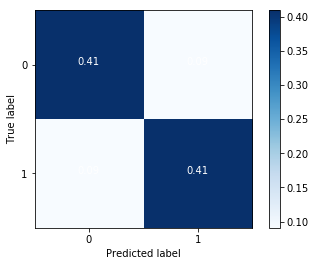

In [78]:

cm=confusion_matrix(np.asarray(y_true).flatten(),y_pred.flatten())/len(y_pred.flatten())
plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks([0,1])
plt.yticks([0,1])
plt.ylabel('True label')
plt.xlabel('Predicted label')

fmt = '.2f' 
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" )

Text(0.5,1,'Distribution of Predicted Sentiment')

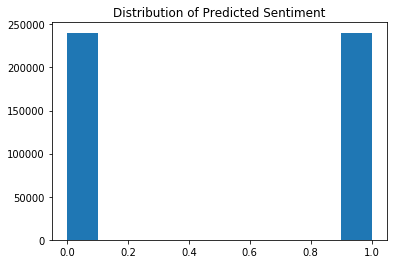

In [79]:
plt.hist(np.round(y_pred).flatten())
plt.title('Distribution of Predicted Sentiment')

In [113]:
reload(utils_proj)
# Testing parameters
max_time = max_time
batch_size = 1
learning_rate = 0.00
num_epochs = 1
reload(lstm)
# Will print status every this many seconds
print_interval = 15

lm = lstm.RNNLM(**model_params)
lm.BuildCoreGraph()
lm.BuildTrainGraph()

with lm.graph.as_default():
    saver = tf.train.Saver()

y_pred=[]
y_true=[]
val_acc=[]
num_equals=[]
    
with tf.Session(graph=lm.graph) as session:
    saver.restore(session, trained_filename)
    
    for epoch in range(1,num_epochs+1):
        t0_epoch = time.time()
        bi = utils_proj.rnnlm_batch_generator(x_ids_candidates, batch_size, max_time)
        print("[epoch {:d}] Starting epoch {:d}".format(epoch, epoch))
    
        for i, w in enumerate(bi):

            if i == 0:
                h = session.run(lm.initial_h_, {lm.input_w_: w})
            feed_dict = {
                lm.input_w_: w,
                lm.initial_h_: h,
            }
            ops = [lm.final_h_,lm.predictions_]        

            h,preds = session.run(ops,feed_dict=feed_dict)
           
            y_pred.append(preds)
            
            if i % 10 ==0:
                print("[epoch {:d}] Completed in {:s}".format(epoch, utils_proj.pretty_timedelta(since=t0_epoch)))
   
y_pred=np.round(y_pred)

INFO:tensorflow:Restoring parameters from ~/w266_final_project/tmp/w266/a3_model/rnnlm_trained
[epoch 1] Starting epoch 1
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:00
[epoch 1] Completed in 0:00:01
[epoch 1] Completed in 0:00:01
[epoch 1] Completed in 0:00:01
[epoch 1] Completed in 0:00:01
[epoch 1] Completed in 0:00:01
[epoch 1] Completed in 0:00:01
[epoch 1] Completed in 0:00:02
[epoch 1] Completed in 0:00:02
[epoch 1] Completed in 0:00:02
[epoch 1] Completed in 0:00:02
[epoch 1] Completed in 0:00:02


In [140]:
tweet_sentiment = pd.DataFrame(y_pred.flatten())
tweet_sentiment['tweet'] = data_candidates['tweet']
tweet_sentiment['Candidate'] = data_candidates['candidate']

tweet_sentiment.to_csv('LSTM_classifications')